# Import libraries

In [90]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
import math
import time
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

tqdm.pandas()

# Reading data

In [59]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [7]:
train.columns

Index(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time', 'rider_id', 'first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'cancelled',
       'undelivered_orders', 'lifetime_order_count', 'reassignment_method',
       'reassignment_reason', 'reassigned_order', 'session_time',
       'cancelled_time'],
      dtype='object')

- `order_id` : unique id for each order
- `order_time`: time of the creation of order by the client
- `order_date` : date of the order
- `allot_time`: time of allocation of order to the rider
- `accept_time`: time of acceptance of the order by the rider (if available)
- `pickup_time`: time of pickup of the order (if available)
- `delivered_time`: time of delivery of the order (if available)
- `cancelled_time`: time of cancellation of order (if the order was cancelled)
- `cancelled`: whether the order was cancelled
- `rider_id`: unique id for each rider
- `first_mile_distance`: road distance from rider’s location to the pickup location
- `last_mile_distance`: road distance from pickup location to the delivery location
- `allotted_orders`: total number of orders allotted to the rider in the 30 days before (not including) order_date
- `delivered_orders`: total number of orders delivered by the rider in the 30 days before (not including) order_date
- `undelivered_orders`: total number of orders allotted to but not delivered by the rider (i.e. cancelled) in the 30 days before (not including) order_date
- `lifetime_order_count`: total number of orders delivered by the rider at any time before order_date
- `reassigned_order`: whether the order was reassigned to this rider
- `reassignment_method`: if the order was reassigned, whether the reassignment was done manually (by the ops team) or automatically
- `reassignment_reason`: a more detailed reason for the reassignment
- `session_time`: total time the rider had been online on order_date before order_time


In [60]:
id_columns = ['order_id']

time_columns = ['order_time', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time','cancelled_time']

categorical_columns = ['reassignment_method','reassignment_reason']

# Converting to datetime and object

In [61]:
ids = train[id_columns]
train = train.drop(ids, axis=1)
test = test.drop(ids,axis=1)

for col in time_columns:
    train[col] = pd.to_datetime(train[col])         # this is where we are converting the data and time strings to datetime objects making it easy to work with
    try:
        test[col] = pd.to_datetime(test[col])
    except:
        continue

for col in categorical_columns:
    train[col] = train[col].astype('object')        # convrting the categorical data into object data type
    try:
        test[col] = test[col].astype('object')
    except:
        continue

In [13]:
train["order_time"][:5]     # converted to datetime object

#train["order_time"][:5].dt     # this is the iterator of the datetime object

0    26
1    26
2    26
3    26
4    26
Name: order_time, dtype: int64

Converting columns in a Pandas DataFrame to the 'object' data type serves several purposes, particularly when dealing with categorical or mixed data types. Here are some reasons why you might want to convert columns to the 'object' data type:

1. **Categorical Data Representation**: The 'object' data type is often used to represent categorical or text data. Categorical data includes values that belong to a limited and fixed set of categories. By converting columns to the 'object' data type, you can explicitly indicate that these columns contain categorical information.

2. **Mixed Data Types**: Sometimes, a column may contain a mixture of data types, including strings, numbers, and other objects. Converting such columns to the 'object' data type allows you to keep the original data intact while still being able to work with it effectively.

3. **Preserving Textual Information**: When a column contains text or strings, converting it to the 'object' data type ensures that the text is preserved as-is without any automatic conversions or numeric interpretations.

4. **Interoperability**: The 'object' data type is flexible and can hold a wide range of data, including strings, numbers, dates, and more. This flexibility can be helpful when dealing with data that doesn't fit neatly into a specific numeric data type.

5. **Grouping and Aggregation**: When you convert categorical columns to 'object', you can more easily group and aggregate data based on those categories. Pandas provides powerful grouping and aggregation functions for categorical data.

6. **Working with External Libraries**: Some external libraries and frameworks may require data in specific formats. Converting columns to the 'object' data type might facilitate compatibility with these libraries.

However, it's important to note that using the 'object' data type for columns may come with some trade-offs. Operations on 'object' data types might be slower compared to operations on specific data types like integers or floats. Also, data type inconsistencies could lead to unexpected behavior or errors.

In the context of the code snippet you provided, converting columns to the 'object' data type likely indicates that those columns contain categorical or mixed data types. It's a way of explicitly representing the nature of the data in those columns, making it easier to work with and perform operations that are relevant to those data types.

# Preprocessing

In [14]:
def peak_hour(x):
    if x>=8 and x<=11:
        return 1
    if x>=13 and x<=19:
        return 1
    return 0

def log_normal(x):
    if x==0:
        return 0
    if x>0:
        return math.log(x)
    else:
        return math.log(abs(x))

In [62]:
def preprocess(df):
    df['order_day'] = df['order_date'].dt.dayofyear # getting day of the year from the datetime object of order_data

    df['diff_allot_order'] = df['allot_time']-df['order_time']  # new column - diff b/w order time and allot time

    df['diff_allot_order'] = df['diff_allot_order'].dt.components['hours']*3600+df['diff_allot_order'].dt.components['minutes']*60+df['diff_allot_order'].dt.components['seconds']  # converting that time diff in seconds

    df['diff_accept_allot'] = df['accept_time']-df['allot_time']
    df['diff_accept_allot'] = df['diff_accept_allot'].dt.components['hours']*3600+df['diff_accept_allot'].dt.components['minutes']*60+df['diff_accept_allot'].dt.components['seconds'] # same thing with time diff in allot acceptance

    df['diff_accept_order'] = df['accept_time']-df['order_time']
    df['diff_accept_order'] = df['diff_accept_order'].dt.components['hours']*3600+df['diff_accept_order'].dt.components['minutes']*60+df['diff_accept_order'].dt.components['seconds']

    df['total_dist'] = df['first_mile_distance']+df['last_mile_distance']

    df['hour_in_day'] = df['order_time'].dt.hour
    df['day_of_week'] = df['order_date'].dt.dayofweek

    df[['cum_diff_allot_order','cum_diff_accept_allot','cum_diff_accept_order','cum_total_dist','cum_first_mile_dist','cum_last_mile_dist']]=df.groupby(['rider_id','order_date'])[['diff_allot_order','diff_accept_allot','diff_accept_order','total_dist','first_mile_distance','last_mile_distance']].cumsum()
    # cummulative data of all these per rider per day

    df['order_today'] = df.groupby(['rider_id','order_date']).cumcount()    # total orders per day
    df['orders_cum'] = df.groupby(['rider_id']).cumcount()  # total order overall

    df['reassigned_order'] = df['reassigned_order'].fillna(0)       # cleaning the column

    df['saturday'] = df['day_of_week'].apply(lambda x:1 if x==5 else 0)

    for col in df.columns:
        if df[col].isnull().sum()>0:        # if in any column no. of null items are >0 we fill those na values with 0
            df[col]=df[col].fillna(0)

    df['orders_diff'] = df['alloted_orders']-df['delivered_orders']

    riders = df.groupby(['order_date','hour_in_day'])['rider_id'].count().to_dict()     # riders available at a particular day and hour of that day

    df['riders_available'] = df.apply(lambda x: riders[(x.order_date,x.hour_in_day)],axis=1)        # rider ids of all the available riders

    df['reliability'] = (df['alloted_orders']-df['undelivered_orders'])*100/df['alloted_orders']

    df['reliability'] = df['reliability'].fillna(0)

    cols = []
    col_dict = ((df.dtypes==int)|(df.dtypes==float)).to_dict()      # getting all the cols whose data types are int or float 

    for col in col_dict.keys():
        if col_dict[col]:
            cols.append(col)
    
    # computing mean std and min-max of all those numeric cols
    df["mean"] = df[cols].mean(axis=1)
    df["std"] = df[cols].std(axis=1)
    df["min"] = df[cols].min(axis=1)
    df["max"] = df[cols].max(axis=1) 
    
    return df

# Train Valid Split

In [107]:
print(test.columns)

Index(['order_time', 'order_date', 'allot_time', 'accept_time', 'rider_id',
       'first_mile_distance', 'last_mile_distance', 'alloted_orders',
       'delivered_orders', 'undelivered_orders', 'lifetime_order_count',
       'reassignment_method', 'reassignment_reason', 'reassigned_order',
       'session_time', 'order_day', 'diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist', 'hour_in_day', 'day_of_week',
       'cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order', 'cum_total_dist', 'cum_first_mile_dist',
       'cum_last_mile_dist', 'order_today', 'orders_cum', 'saturday',
       'orders_diff', 'riders_available', 'reliability', 'mean', 'std', 'min',
       'max'],
      dtype='object')


In [63]:
train_df = train[:395778]
valid_df = train[395778:]
train_df = preprocess(train_df)
valid_df = preprocess(valid_df)
test_df= preprocess(test)

# the warning below indicate that we have tried to alter the values of the subsets of our dataframe and this doesn't change the original data though

C:\Users\mayba\AppData\Local\Temp\ipykernel_21376\385797585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_day'] = df['order_date'].dt.dayofyear # getting day of the year from the datetime object of order_data
C:\Users\mayba\AppData\Local\Temp\ipykernel_21376\385797585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_allot_order'] = df['allot_time']-df['order_time']  # new column - diff b/w order time and allot time
C:\Users\mayba\AppData\Local\Temp\ipykernel_21376\385797585.py:6:

In [52]:
#print(test_df.shape)
print(valid_df.shape)
print(train_df.shape)

(54222, 42)
(395778, 42)


# Rider details feature engineering

In [53]:
train_df.columns
valid_df.columns

Index(['order_time', 'order_date', 'allot_time', 'accept_time', 'pickup_time',
       'delivered_time', 'rider_id', 'first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'cancelled',
       'undelivered_orders', 'lifetime_order_count', 'reassignment_method',
       'reassignment_reason', 'reassigned_order', 'session_time',
       'cancelled_time', 'order_day', 'diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist', 'hour_in_day', 'day_of_week',
       'cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order', 'cum_total_dist', 'cum_first_mile_dist',
       'cum_last_mile_dist', 'order_today', 'orders_cum', 'saturday',
       'orders_diff', 'riders_available', 'reliability', 'mean', 'std', 'min',
       'max'],
      dtype='object')

In [64]:
rider_cols_mean = ['session_time', 'first_mile_distance','last_mile_distance','total_dist']

df = pd.concat([train_df,valid_df,test_df])

data = df.groupby('rider_id').cumsum()[rider_cols_mean]
data['cumcounts'] = df.groupby('rider_id').cumcount()
data['cumcounts'] = data['cumcounts']+1

for i in ['session_time', 'first_mile_distance', 'last_mile_distance', 'total_dist']:       # computing the avg of all these components for for each rider
    data[i] = data[[i,'cumcounts']].progress_apply(lambda x:x[i]/x['cumcounts'],axis=1)

C:\Users\mayba\AppData\Local\Temp\ipykernel_21376\2741140223.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = df.groupby('rider_id').cumsum()[rider_cols_mean]
100%|██████████| 594844/594844 [00:05<00:00, 109148.65it/s]


In [65]:
rider_deets = data.copy()
rider_deets[500:510]

,session_time,first_mile_distance,last_mile_distance,total_dist,cumcounts
500,37.250000,1.049406,1.175000,2.224406,2
501,40.261111,1.439267,4.136667,5.575933,3
502,101.516667,0.184236,1.420000,1.604236,1
503,48.977778,1.392267,3.543333,4.935600,3
504,0.000000,1.794400,1.890000,3.684400,1
505,35.800000,1.957600,1.090000,3.047600,1
506,34.788889,0.882033,2.626667,3.508700,3
507,94.783333,1.180660,1.900000,3.080660,5
508,51.105556,0.757407,4.586667,5.344073,3
509,58.683333,1.509900,4.300000,5.809900,1


In [66]:
time_columns = ['order_time', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time','cancelled_time']
numerical_columns = ['first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'lifetime_order_count',
                    'session_time','diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist','cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order', 'cum_total_dist', 'allotted_orders',
                     'riders_available','orders_cum','reliability']
categorical_columns = ['reassignment_method','reassignment_reason','reassigned_order','order_day','hour_in_day','undelivered_orders','day_of_week',
                       'order_today', 'allotted', 'deliveries','period_in_day','saturday','first_mile', 'last_mile','orders_diff']

# Undersampling negative class and combining

In [87]:
print(train_df[train_df["cancelled"]==1].count())

# print(train_df[train_df["cancelled"]==0].count())



order_time               4614
order_date               4614
allot_time               4614
accept_time              4614
pickup_time              4614
delivered_time           4614
rider_id                 4614
first_mile_distance      4614
last_mile_distance       4614
alloted_orders           4614
delivered_orders         4614
cancelled                4614
undelivered_orders       4614
lifetime_order_count     4614
reassignment_method      4614
reassignment_reason      4614
reassigned_order         4614
session_time             4614
cancelled_time           4614
order_day                4614
diff_allot_order         4614
diff_accept_allot        4614
diff_accept_order        4614
total_dist               4614
hour_in_day              4614
day_of_week              4614
cum_diff_allot_order     4614
cum_diff_accept_allot    4614
cum_diff_accept_order    4614
cum_total_dist           4614
cum_first_mile_dist      4614
cum_last_mile_dist       4614
order_today              4614
orders_cum

In [67]:
train_df_c = train_df[train_df['cancelled']==1].sample(int(train_df[train_df['cancelled']==1].shape[0]*1),replace=False,random_state=42)
train_df_d = train_df[train_df['cancelled']==0].sample(int(train_df_c.shape[0])*1,random_state=42)

# we are creating the same no. of samples for all both cancelled and not cancelled case
# we are undersampling the negative class ie cancelled==0 class here and bringing it down to cancelled==1 no. of examples

In [ ]:
# lets try over sampling
smote = S

In [88]:
combined_df = pd.concat([train_df_c,train_df_d])
combined_df = combined_df.sort_values('order_time')   # these are gonna act as our labels

print(combined_df.shape)

(9228, 42)


In [69]:
valid_df_c = valid_df[valid_df['cancelled']==1].sample(int(valid_df[valid_df['cancelled']==1].shape[0]*1),replace=False,random_state=42)
valid_df_d = valid_df[valid_df['cancelled']==0].sample(int(valid_df_c.shape[0])*1,random_state=42)

In [89]:
combined_df_valid = pd.concat([valid_df_c,valid_df_d])
combined_df_valid = combined_df_valid.sort_values('order_time')   # these are gonna act as our labels

combined_df_valid.shape

(1208, 42)

In [98]:
print(train_df.shape)
print(test_df.shape)

(395778, 42)
(144844, 38)


In [77]:
cols = ['first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders',
       'undelivered_orders', 'lifetime_order_count',
       'session_time',
       'order_day', 'diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist', 'hour_in_day', 'day_of_week','cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order','reassigned_order',
       'cum_total_dist', 'order_today','rider_id','orders_cum',
       'saturday','orders_diff','riders_available','cum_first_mile_dist','cum_last_mile_dist','reliability','mean','std','min','max']


# Combining datasets with details about the rider

In [91]:
print(combined_df.shape)
print(train_df.shape)
# print(rider_deets.shape)
# print(test_df.shape)

# print(rider_deets[-test_df.shape[0]:].shape)

(9228, 42)
(395778, 42)


In [94]:
train_df.columns

Index(['order_time', 'order_date', 'allot_time', 'accept_time', 'pickup_time',
       'delivered_time', 'rider_id', 'first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'cancelled',
       'undelivered_orders', 'lifetime_order_count', 'reassignment_method',
       'reassignment_reason', 'reassigned_order', 'session_time',
       'cancelled_time', 'order_day', 'diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist', 'hour_in_day', 'day_of_week',
       'cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order', 'cum_total_dist', 'cum_first_mile_dist',
       'cum_last_mile_dist', 'order_today', 'orders_cum', 'saturday',
       'orders_diff', 'riders_available', 'reliability', 'mean', 'std', 'min',
       'max'],
      dtype='object')

In [80]:
combined_df = combined_df[cols+['cancelled']]
combined_df = pd.merge(combined_df,rider_deets[train_df.shape[0]:],left_index=True,right_index=True)   # including only train examples in driver deets

X_train = combined_df.drop('cancelled',axis=1)
y_train = combined_df['cancelled']


combined_df_valid = combined_df_valid[cols+['cancelled']]
combined_df_valid = pd.merge(combined_df_valid,rider_deets[train_df.shape[0]:-test_df.shape[0]],left_index=True,right_index=True)     # including only validation examples of driver deets      

X_test = combined_df_valid.drop('cancelled',axis=1)
y_test = combined_df_valid['cancelled']

In [81]:
print(X_train.shape)
print(X_test.shape)

(3312, 37)
(1208, 37)


In [105]:
og_trn = train_df[cols+["cancelled"]]
og_trn = pd.merge(og_trn,rider_deets[train_df.shape[0]:],left_index=True,right_index=True)

X_train = combined_df.drop('cancelled',axis=1)
y_train = combined_df['cancelled']


In [103]:
og_tst = test_df[cols]
og_tst = pd.merge(og_tst,rider_deets[-test_df.shape[0]:],left_index=True,right_index=True)

print(og_tst.shape)


(144844, 37)


# Predictions
### All model hyperparameters were tuned using XGBoost Optuna or GridSearch

# Random Forests Classifier

In [82]:
params = {'n_estimators': 900, 'max_depth': 40, 'random_state': 2020, 'min_samples_split': 10, 'min_samples_leaf': 2}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=900, random_state=2020)

In [83]:
rf_preds = rf.predict(X_test)
rf_preds_prob = rf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       604
           1       0.77      0.52      0.62       604

    accuracy                           0.68      1208
   macro avg       0.71      0.68      0.68      1208
weighted avg       0.71      0.68      0.68      1208

Test Accuracy:  0.6846026490066225
Train Accuracy:  0.9779589371980676
AUC Score: 0.7316948818034296


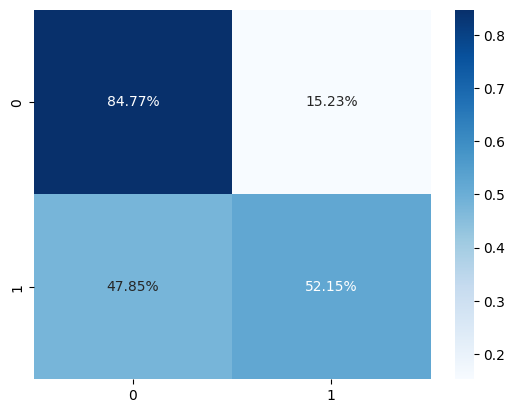

In [84]:
result = confusion_matrix(y_test, rf_preds)
r = np.sum(result,axis=1)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
print(classification_report(y_test,rf_preds))
print('Test Accuracy: ',rf.score(X_test,y_test))
print('Train Accuracy: ',rf.score(X_train,y_train))
print('AUC Score:',roc_auc_score(y_test,rf_preds_prob))

# XGBoost Classifier

In [ ]:
params = {'lambda': 0.20177241158844367, 'alpha': 3.4670054832209787, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 37}

xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train,eval_metric='auc')
xgby_pred = xgb_model.predict(X_test)
xgby_preds_prob = xgb_model.predict_proba(X_test)[:,1]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
Train Accuracy:  0.7109882964889467
Test Accuracy: 0.8759544096492199
AUC Score: 0.7360545713495938


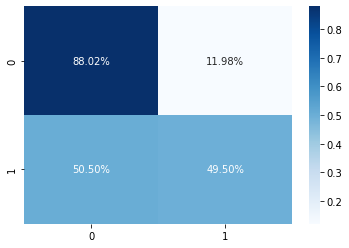

In [ ]:
result = confusion_matrix(y_test, xgby_pred)
r = np.sum(result,axis=1)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
result1 = classification_report(y_test, xgby_pred)
print("Classification Report:",)
result2 = accuracy_score(y_test,xgby_pred)
print('Train Accuracy: ',xgb_model.score(X_train,y_train))
print("Test Accuracy:",result2)
print('AUC Score:',roc_auc_score(y_test,xgby_preds_prob))

# KNeighborsClassifier

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 25,weights='distance')
classifier.fit(X_train, y_train)
knny_pred = classifier.predict(X_test)
knny_preds_prob = classifier.predict_proba(X_test)[:,1]

Classification Report:               precision    recall  f1-score   support

           0       0.99      0.87      0.92     53618
           1       0.03      0.36      0.05       604

    accuracy                           0.86     54222
   macro avg       0.51      0.61      0.49     54222
weighted avg       0.98      0.86      0.92     54222

Train Accuracy:  1.0
Test Accuracy: 0.8610158238353436
AUC Score: 0.6575774321117328


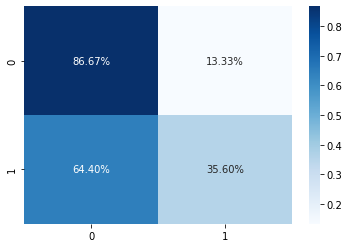

In [ ]:
result = confusion_matrix(y_test, knny_pred)
r = np.sum(result,axis=1)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
result1 = classification_report(y_test, knny_pred)
print("Classification Report:",result1)
result2 = accuracy_score(y_test,knny_pred)
print('Train Accuracy: ',classifier.score(X_train,y_train))
print("Test Accuracy:",result2)
print('AUC Score:',roc_auc_score(y_test,knny_preds_prob))

# AdaBoost Classifier

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     53618
           1       0.03      0.57      0.06       604

    accuracy                           0.81     54222
   macro avg       0.51      0.69      0.48     54222
weighted avg       0.98      0.81      0.89     54222

Train Accuracy:  0.7196575639358475
Test Accuracy:  0.8109623400095902
AUC Score: 0.7421973945440383


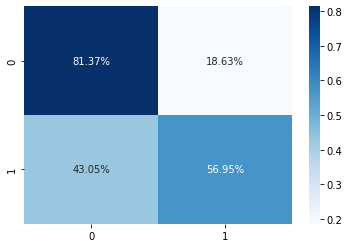

In [ ]:
abclassifier = AdaBoostClassifier(n_estimators=1000,learning_rate=0.1)
abclassifier.fit(X_train, y_train)
aby_pred = abclassifier.predict(X_test)
aby_preds_prob = abclassifier.predict_proba(X_test)[:,1]
result = confusion_matrix(y_test, aby_pred)
r = np.sum(result,axis=1)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
print(classification_report(y_test, aby_pred))

print('Train Accuracy: ',abclassifier.score(X_train,y_train))
print('Test Accuracy: ',abclassifier.score(X_test,y_test))

print('AUC Score:',roc_auc_score(y_test,aby_preds_prob))

# Checking ensemble results for validation data

[[46331  7287]
 [  282   322]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     53618
           1       0.04      0.53      0.08       604

    accuracy                           0.86     54222
   macro avg       0.52      0.70      0.50     54222
weighted avg       0.98      0.86      0.92     54222

AUC Score:  0.7432780246526879


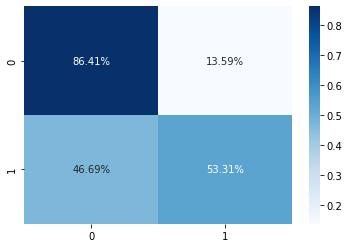

In [ ]:
check = pd.DataFrame()
check['rf_pred'] = rf_preds_prob
check['xgb_pred'] = xgby_preds_prob
check['knn_pred'] = knny_preds_prob
check['ada_pred'] = aby_preds_prob
check['sums'] = check[['rf_pred','xgb_pred','ada_pred']].mean(axis=1)
check['cancelled'] = y_test.reset_index()['cancelled']
check['pred'] = check['sums'].apply(lambda x: 1 if x>=0.5 else 0)
result = confusion_matrix(y_test, check['pred'])
print(result)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
print(classification_report(y_test, check['pred']))
print("AUC Score: ",roc_auc_score(y_test,check['sums']))

# Predicting on test data and submission

In [ ]:
test_df = test_df[cols]
test_data = pd.merge(test_df,rider_deets[rider_deets.shape[0]//2:],left_index=True,right_index=True)

In [ ]:
y_preds_rf = rf.predict_proba(test_data)[:,1]
y_preds_xgb = xgb_model.predict_proba(test_data)[:,1]
y_preds_ada = abclassifier.predict_proba(test_data)[:,1]
y_preds_knn = classifier.predict_proba(test_data)[:,1]

In [ ]:
sub = pd.DataFrame(columns = ['order_id'])
sub['order_id'] = pd.read_csv('../input/cascade-cup-22/test.csv')['order_id']
sub['rf_pred'] = y_preds_rf
sub['xgb_pred'] = y_preds_xgb
sub['ada_pred'] = y_preds_ada
sub['knn_pred'] = y_preds_knn
sub['sums'] = sub[['rf_pred','xgb_pred','ada_pred']].mean(axis=1)
sub['cancelled'] = sub['sums'].apply(lambda x: x)
sub

,order_id,rf_pred,lgb_pred,xgb_pred,ada_pred,knn_pred,cat_pred,sums,cancelled
0,130231,0.326520,0.472883,0.394723,0.500141,0.310628,0.351581,0.357608,0.357608
1,130232,0.301476,0.477924,0.421332,0.499012,0.413232,0.138844,0.287217,0.287217
2,130233,0.311470,0.450105,0.352763,0.498999,0.244146,0.273005,0.312413,0.312413
3,130234,0.389478,0.463086,0.389463,0.499904,0.187050,0.374400,0.384447,0.384447
4,130235,0.332612,0.450253,0.339454,0.499133,0.324717,0.271001,0.314356,0.314356
...,...,...,...,...,...,...,...,...,...
144839,41184,0.364317,0.457743,0.389816,0.498787,0.414154,0.274086,0.342739,0.342739
144840,41185,0.349903,0.443502,0.344096,0.499903,0.326938,0.519332,0.404444,0.404444
144841,41186,0.372121,0.448354,0.366995,0.499008,0.221701,0.371994,0.370370,0.370370
144842,41187,0.493329,0.476625,0.382035,0.500958,0.512572,0.437195,0.437519,0.437519


<AxesSubplot:xlabel='cancelled', ylabel='Density'>

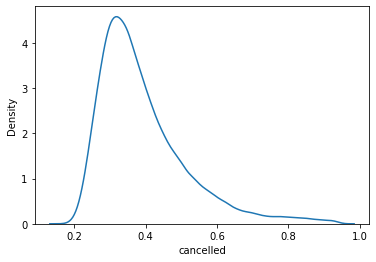

In [ ]:
sns.kdeplot(sub['cancelled'])

In [ ]:
sub[['order_id','cancelled']].to_csv('submission.csv',index=False)